<a href="https://colab.research.google.com/github/rania-azad/DeepLearning-Course---Limiteless/blob/main/Week%204%20%3A%20%20Hands-on%20Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔄 Transfer Learning

Most of the time, training an entire convolutional network from scratch is impractical. Training state-of-the-art ConvNets on large datasets like ImageNet can take weeks, even with multiple GPUs.
> Instead, a common approach is to use a pretrained network. This can be either as a fixed feature extractor or as a base model for further fine-tuning.

In this notebook, we'll use [VGGNet](https://arxiv.org/pdf/1409.1556.pdf), which has been trained on the [ImageNet dataset](http://www.image-net.org/), as a feature extractor. Here's an overview of VGGNet's architecture: it comprises a series of convolutional and maxpooling layers, followed by three fully-connected layers. These layers are designed to classify the 1000 classes found in the ImageNet database.

🌟 **Why VGGNet?**
VGGNet is known for both its simplicity and effectiveness, achieving second place in the ImageNet competition. Our strategy involves leveraging VGGNet's convolutional layers while replacing its final fully-connected layer with our own classifier. This allows us to use VGGNet as a _fixed feature extractor_ for our images, upon which we can easily train a custom classifier.
* We'll utilize all but the last fully-connected layer of VGGNet for feature extraction.
* We'll introduce a new final classification layer tailored to our specific task!

For more insights on transfer learning, check out the [CS231n Stanford course notes](http://cs231n.github.io/transfer-learning/).


## Flower photos

Here we'll be using VGGNet to classify images of flowers. We'll start, as usual, by importing our usual resources. And checking if we can train our model on GPU.

### Download Data

Download the flower data from [this link](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip), save it in the home directory of this notebook and extract the zip file to get the directory `flower_photos/`. **Make sure the directory has this exact name for accessing data: flower_photos**.

In [1]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip

--2024-08-14 11:44:54--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.80.126, 52.217.33.142, 52.216.57.200, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.80.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229734282 (219M) [application/zip]
Saving to: ‘flower-photos.zip’

flower-photos.zip   100%[===================>] 219.09M  13.9MB/s    in 18s     

2024-08-14 11:45:13 (12.0 MB/s) - ‘flower-photos.zip’ saved [229734282/229734282]



In [7]:
!unzip flower-photos.zip

Archive:  flower-photos.zip
   creating: flower_photos/
  inflating: flower_photos/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/flower_photos/
  inflating: __MACOSX/flower_photos/._.DS_Store  
  inflating: flower_photos/LICENSE.txt  
   creating: flower_photos/test/
  inflating: flower_photos/test/.DS_Store  
   creating: __MACOSX/flower_photos/test/
  inflating: __MACOSX/flower_photos/test/._.DS_Store  
   creating: flower_photos/test/daisy/
  inflating: flower_photos/test/daisy/14332947164_9b13513c71_m.jpg  
  inflating: flower_photos/test/daisy/14333681205_a07c9f1752_m.jpg  
  inflating: flower_photos/test/daisy/14350958832_29bdd3a254.jpg  
  inflating: flower_photos/test/daisy/14354051035_1037b30421_n.jpg  
  inflating: flower_photos/test/daisy/14372713423_61e2daae88.jpg  
  inflating: flower_photos/test/daisy/14399435971_ea5868c792.jpg  
  inflating: flower_photos/test/daisy/14402451388_56545a374a_n.jpg  
  inflating: flower_photos/test/daisy/14421389519_d5fd353eb4.jpg

In [8]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load and Transform our Data

We'll be using PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class which makes it very easy to load data from a directory. For example, the training images are all stored in a directory path that looks like this:
```
root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
```

Where, in this case, the root folder for training is `flower_photos/train/` and the classes are the names of flower types.

In [11]:
# define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Transforming the Data

When we perform transfer learning, we have to shape our input data into the shape that the pre-trained model expects. VGG16 expects `224`-dim square images as input and so, we resize each flower image to fit this mold.

In [12]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


### DataLoaders and Data Visualization

In [13]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)

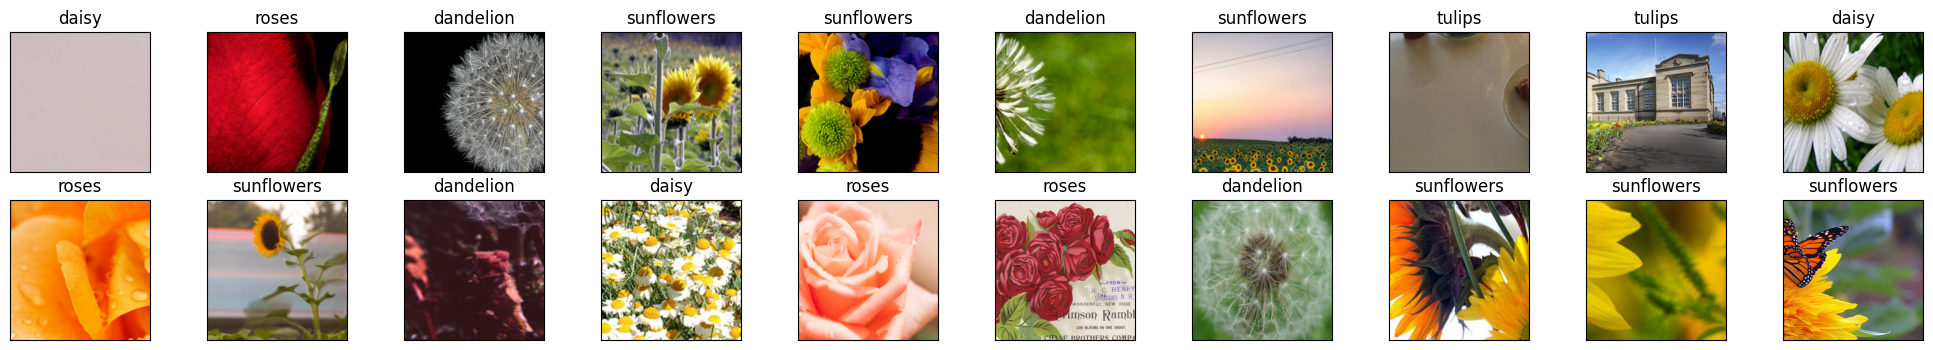

In [14]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

---
## Define the Model

To define a model for training we'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will *not* change during training.**

In [17]:
# Load the pretrained model from pytorch
# Take filters/points from VGG16=True
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 70.4MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
#Linear(in_features=4096, out_features=1000, bias=True)
print(vgg16.classifier[6].in_features)
print(vgg16.classifier[6].out_features)




4096
1000


In [19]:
# Freeze training for all "features" layers - Fine tuning the network,
for param in vgg16.features.parameters():
    param.requires_grad = False


---
### Final Classifier Layer

Once you have the pre-trained feature extractor, you just need to modify and/or add to the final, fully-connected classifier layers. In this case, we suggest that you repace the last layer in the vgg classifier group of layers.
> This layer should see as input the number of features produced by the portion of the network that you are not changing, and produce an appropriate number of outputs for the flower classification task.

You can access any layer in a pretrained network by name and (sometimes) number, i.e. `vgg16.classifier[6]` is the sixth layer in a group of layers named "classifier".

In [20]:
import torch.nn as nn
#input layers
n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
# We have to change final classifier layer, so output needs to be same like dataset of flower len(classes)
#
last_layer = nn.Linear(n_inputs, len(classes))

# Last layer should be changed to last_layer
vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

5


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Below we'll use cross-entropy loss and stochastic gradient descent with a small learning rate. Note that the optimizer accepts as input _only_ the trainable parameters `vgg.classifier.parameters()`.

In [21]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

---
## Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help.

In [22]:
# number of epochs to train the model
n_epochs = 2

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()

        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 1.5237844467163086
Epoch 1, Batch 40 loss: 1.4053855597972871
Epoch 1, Batch 60 loss: 1.2406604111194610
Epoch 1, Batch 80 loss: 1.1279892265796660
Epoch 1, Batch 100 loss: 1.0544402241706847
Epoch 1, Batch 120 loss: 0.9736994117498398
Epoch 1, Batch 140 loss: 0.9247118026018143
Epoch 2, Batch 20 loss: 0.8808408439159393
Epoch 2, Batch 40 loss: 0.8493452817201614
Epoch 2, Batch 60 loss: 0.7845739811658859
Epoch 2, Batch 80 loss: 0.8497095674276351
Epoch 2, Batch 100 loss: 0.8080890357494355
Epoch 2, Batch 120 loss: 0.8215311408042908
Epoch 2, Batch 140 loss: 0.6870737180113793


---
## Testing

Below you see the test accuracy for each flower class.

In [23]:
# track test loss
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.684633

Test Accuracy of daisy: 77% (71/92)
Test Accuracy of dandelion: 92% (122/132)
Test Accuracy of roses: 64% (59/91)
Test Accuracy of sunflowers: 79% (80/101)
Test Accuracy of tulips: 72% (90/124)

Test Accuracy (Overall): 78% (422/540)


### Visualize Sample Test Results

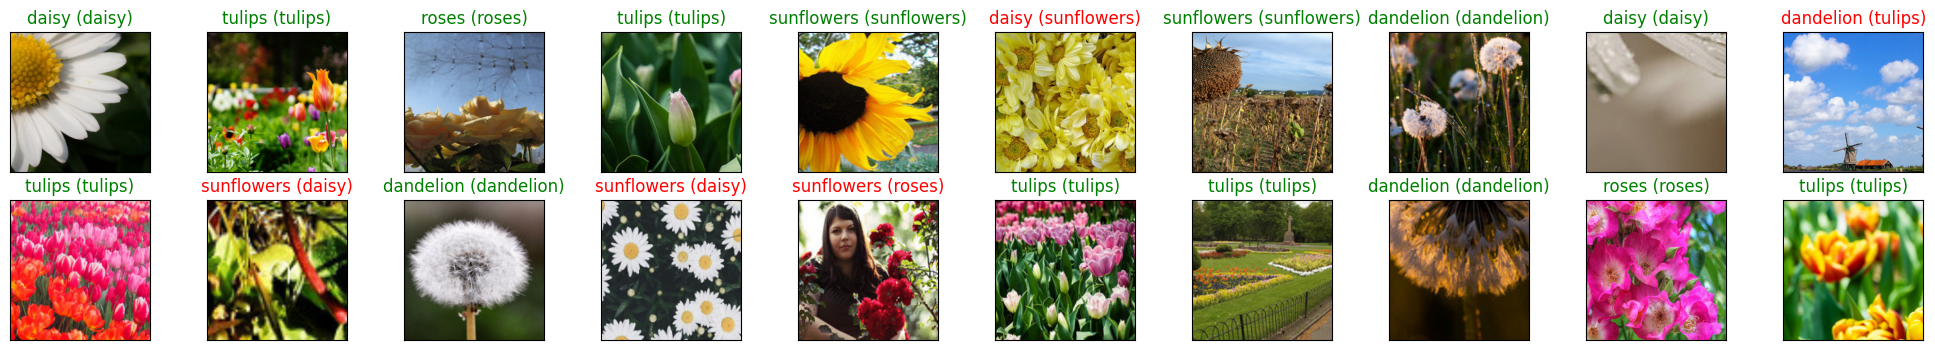

In [24]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))